In [13]:
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import os

def preprocess_adata(adata):
    # QC filtering
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.pct_counts_mt < 5, :]

    # Normalize + log
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # HVGs
    sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)

    # PCA + neighbors + clustering
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)

    return adata


In [3]:
!pip3 install igraph

  Using cached igraph-0.11.9-cp39-abi3-win_amd64.whl.metadata (4.5 kB)
  Using cached texttable-1.7.0-py2.py3-none-any.whl.metadata (9.8 kB)
Using cached igraph-0.11.9-cp39-abi3-win_amd64.whl (2.9 MB)
Using cached texttable-1.7.0-py2.py3-none-any.whl (10 kB)

   -------------------- ------------------- 1/2 [igraph]
   -------------------- ------------------- 1/2 [igraph]
   -------------------- ------------------- 1/2 [igraph]
   -------------------- ------------------- 1/2 [igraph]
   -------------------- ------------------- 1/2 [igraph]
   -------------------- ------------------- 1/2 [igraph]
   -------------------- ------------------- 1/2 [igraph]
   ---------------------------------------- 2/2 [igraph]



In [5]:
!pip3 install leidenalg

  Using cached leidenalg-0.10.2-cp38-abi3-win_amd64.whl.metadata (10 kB)
Using cached leidenalg-0.10.2-cp38-abi3-win_amd64.whl (1.6 MB)


In [14]:
adata_gt = sc.read_h5ad("Data/combined_raw.h5ad")
adata_gt = preprocess_adata(adata_gt)


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.ob

In [12]:
results = []
missing_fractions = [10, 20, 30]
runs = range(1, 11)

for mf in missing_fractions:  
    for run in runs:
        fname = f"Imputed_KNN_h5ad/adata_dropout_mf{mf}_run{run}_knn_imputed.h5ad"
        if not os.path.exists(fname):
            print(f"Skipping {fname} (not found)")
            continue
        
        adata_imp = sc.read_h5ad(fname)
        adata_imp = preprocess_adata(adata_imp)
        
        # Compute ARI between GT and imputed Leiden clusters
        ari = adjusted_rand_score(adata_gt.obs['leiden'], adata_imp.obs['leiden'])
        
        results.append({
            "method": "MAGIC",
            "missing_fraction": mf/100,  # e.g., 0.1, 0.2, 0.3
            "run": run,
            "ARI": ari  
        })

results_df = pd.DataFrame(results)


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


ValueError: Found input variables with inconsistent numbers of samples: [14746, 53]

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summary table
summary = results_df.groupby(['method','missing_fraction'])['ARI'].agg(['mean','std']).reset_index()
print(summary)

# Barplot with error bars
plt.figure(figsize=(8,6))
sns.barplot(data=summary, x='missing_fraction', y='mean', hue='method', capsize=0.1)

# Add SD error bars manually
for i, row in summary.iterrows():
    plt.errorbar(x=i%3 + (0 if row['method']=='MAGIC' else 0.3),
                 y=row['mean'], yerr=row['std'], fmt='none', c='black', capsize=5)

plt.ylabel("ARI (mean ± SD)")
plt.xlabel("Missing Fraction")
plt.title("Clustering Accuracy after Imputation")
plt.savefig('ARI_Summary_knn.png', dpi=300)
plt.show()


NameError: name 'results_df' is not defined

c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.ob

  method  missing_fraction      mean       std
0  MAGIC               0.1  0.390713  0.016998
1  MAGIC               0.2  0.311095  0.015767
2  MAGIC               0.3  0.256196  0.010226


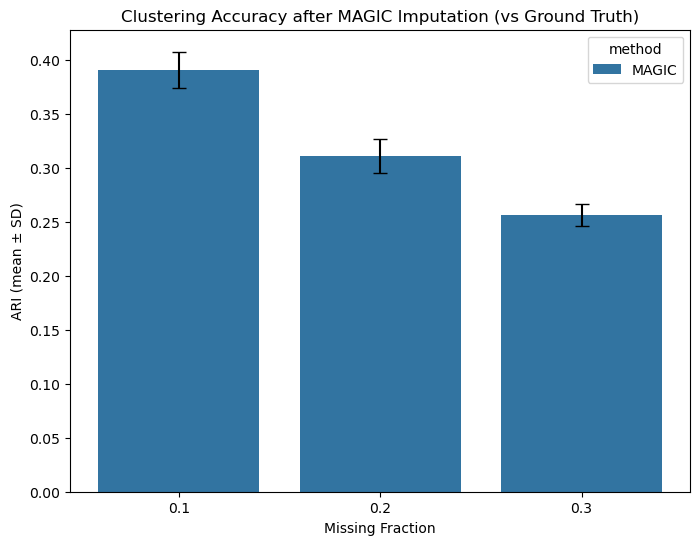

In [1]:
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

def preprocess_adata(adata):
    # QC filtering
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.pct_counts_mt < 5, :]

    # Normalize + log
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # HVGs
    sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)

    # PCA + neighbors + clustering
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)

    return adata


# -----------------------------
# Ground truth clustering
# -----------------------------
adata_gt = sc.read_h5ad("Data/combined_raw.h5ad")
adata_gt = preprocess_adata(adata_gt)
gt_labels = adata_gt.obs['leiden'].copy()

results = []
missing_fractions = [10, 20, 30]
runs = range(1, 11)

# -----------------------------
# Loop over MAGIC-imputed datasets
# -----------------------------
for mf in missing_fractions:  
    for run in runs:
        fname = f"Imputed_h5ad/adata_magic_imputed_mf{mf}_run{run}.h5ad"
        if not os.path.exists(fname):
            print(f"Skipping {fname} (not found)")
            continue
        
        adata_imp = sc.read_h5ad(fname)
        adata_imp = preprocess_adata(adata_imp)
        
        # Make sure cells match between GT and imputed
        common_cells = adata_gt.obs_names.intersection(adata_imp.obs_names)
        gt_sub = gt_labels.loc[common_cells]
        imp_sub = adata_imp.obs['leiden'].loc[common_cells]
        
        # Compute ARI
        ari = adjusted_rand_score(gt_sub, imp_sub)
        
        results.append({
            "method": "MAGIC",   # method label updated
            "missing_fraction": mf/100,  # e.g., 0.1, 0.2, 0.3
            "run": run,
            "ARI": ari  
        })

# -----------------------------
# Results → DataFrame
# -----------------------------
results_df = pd.DataFrame(results)

# Summary table
summary = results_df.groupby(['method','missing_fraction'])['ARI'].agg(['mean','std']).reset_index()
print(summary)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8,6))
sns.barplot(data=summary, x='missing_fraction', y='mean', hue='method', capsize=0.1)

# Add SD error bars manually
for i, row in summary.iterrows():
    plt.errorbar(
        x=i%3 + (0 if row['method']=='MAGIC' else 0.3),
        y=row['mean'], 
        yerr=row['std'], 
        fmt='none', c='black', capsize=5
    )

plt.ylabel("ARI (mean ± SD)")
plt.xlabel("Missing Fraction")
plt.title("Clustering Accuracy after MAGIC Imputation (vs Ground Truth)")
plt.savefig('ARI_Summary_MAGIC.png', dpi=300)
plt.show()


 Preprocessing ground truth...


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf10_run1.h5ad: ARI=0.428


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf10_run10.h5ad: ARI=0.415


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf10_run2.h5ad: ARI=0.412


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf10_run3.h5ad: ARI=0.391


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf10_run4.h5ad: ARI=0.394


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf10_run5.h5ad: ARI=0.428


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf10_run6.h5ad: ARI=0.420


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf10_run7.h5ad: ARI=0.355


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf10_run8.h5ad: ARI=0.412


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf10_run9.h5ad: ARI=0.407


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf20_run1.h5ad: ARI=0.378


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf20_run10.h5ad: ARI=0.402
✅ Processed adata_iterative_imputed_mf20_run2.h5ad: ARI=0.367


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf20_run3.h5ad: ARI=0.357
✅ Processed adata_iterative_imputed_mf20_run4.h5ad: ARI=0.372


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf20_run5.h5ad: ARI=0.434


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf20_run6.h5ad: ARI=0.390


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf20_run7.h5ad: ARI=0.336


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf20_run8.h5ad: ARI=0.350


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_iterative_imputed_mf20_run9.h5ad: ARI=0.397
✅ Processed adata_iterative_imputed_mf30_run1.h5ad: ARI=0.344
✅ Processed adata_iterative_imputed_mf30_run10.h5ad: ARI=0.230
✅ Processed adata_iterative_imputed_mf30_run2.h5ad: ARI=0.322
✅ Processed adata_iterative_imputed_mf30_run3.h5ad: ARI=0.274
✅ Processed adata_iterative_imputed_mf30_run4.h5ad: ARI=0.318
✅ Processed adata_iterative_imputed_mf30_run5.h5ad: ARI=0.281
✅ Processed adata_iterative_imputed_mf30_run6.h5ad: ARI=0.284
✅ Processed adata_iterative_imputed_mf30_run7.h5ad: ARI=0.389
✅ Processed adata_iterative_imputed_mf30_run8.h5ad: ARI=0.266
✅ Processed adata_iterative_imputed_mf30_run9.h5ad: ARI=0.317

Summary (mean ± std):
             method  missing_fraction  ARI_mean   ARI_std  runs
0  IterativeImputer               0.1  0.406265  0.021766    10
1  IterativeImputer               0.2  0.378428  0.028595    10
2  IterativeImputer               0.3  0.302539  0.045130    10


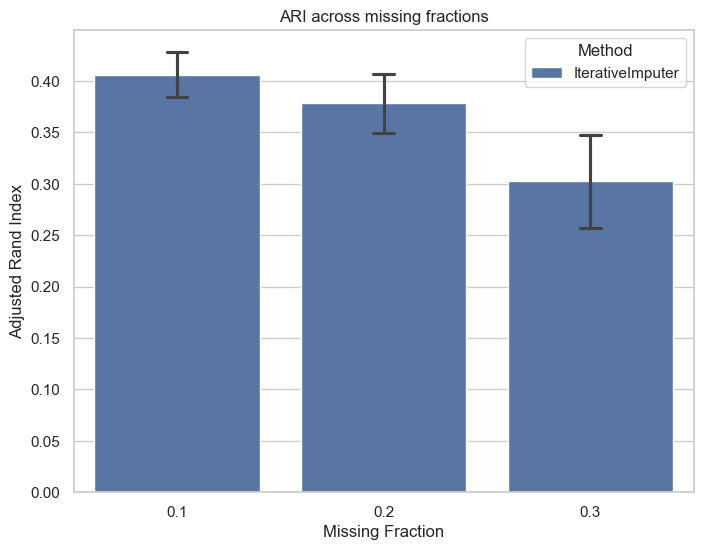

In [11]:
# Notebook 04: Performance Evaluation & Figures

import scanpy as sc
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari_score

# -----------------------------
# Settings
# -----------------------------
sc.settings.verbosity = 0
sns.set(style="whitegrid")

ground_truth_path = "Data/adata_raw_qc.h5ad"         # ground truth file
imputed_dir = "imputed_iterative"                    # folder with imputed h5ad files
methods = ["IterativeImputer"]                       # method tag for plotting

# -----------------------------
# Preprocessing function
# -----------------------------
def preprocess_adata(adata, n_hvgs=1000):
    """Preprocess AnnData: unique names, HVGs, PCA, clustering."""
    adata = adata.copy()

    # Ensure unique obs/var names
    adata.obs_names_make_unique()
    adata.var_names_make_unique()

    # Handle NaNs/Infs in expression matrix
    X = adata.X.A if hasattr(adata.X, "A") else adata.X
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    adata.X = X

    # Apply log1p only if data not already logged
    if np.max(adata.X) > 30:
        sc.pp.log1p(adata)

    # HVG selection
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_hvgs)
    adata = adata[:, adata.var["highly_variable"]].copy()

    # PCA + neighbors + clustering
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata


# -----------------------------
# Load ground truth
# -----------------------------
print(" Preprocessing ground truth...")
adata_gt = sc.read_h5ad(ground_truth_path)
adata_gt = preprocess_adata(adata_gt)

if "leiden" not in adata_gt.obs:
    raise ValueError("Ground truth AnnData does not have 'leiden' clustering.")


# -----------------------------
# Evaluate imputation runs
# -----------------------------
results = []

for fname in os.listdir(imputed_dir):
    if not fname.endswith(".h5ad"):
        continue

    fpath = os.path.join(imputed_dir, fname)
    try:
        adata_imp = sc.read_h5ad(fpath)
        adata_imp = preprocess_adata(adata_imp)

        # Align cells
        common_cells = adata_gt.obs_names.intersection(adata_imp.obs_names)
        adata_gt_sub = adata_gt[common_cells]
        adata_imp_sub = adata_imp[common_cells]

        # Compute ARI
        ari = ari_score(adata_gt_sub.obs["leiden"], adata_imp_sub.obs["leiden"])

        # Parse metadata from filename (mfXX, runX)
        mf = None
        run = None
        for part in fname.split("_"):
            if part.startswith("mf"):
                mf = float(part.replace("mf", "").replace(".h5ad", "")) / 100
            if part.startswith("run"):
                run = int(part.replace("run", "").replace(".h5ad", ""))

        results.append({
            "file": fname,
            "method": "IterativeImputer",
            "ARI": ari,
            "missing_fraction": mf,
            "run": run
        })

        print(f"✅ Processed {fname}: ARI={ari:.3f}")

    except Exception as e:
        print(f"❌ Error with {fname}: {e}")


# -----------------------------
# Results → DataFrame
# -----------------------------
results_df = pd.DataFrame(results)

if results_df.empty:
    raise ValueError("No results computed. Check your imputed files and pipeline.")

results_df = results_df.dropna(subset=["ARI", "missing_fraction"])
results_df["missing_fraction"] = results_df["missing_fraction"].astype(float)

# -----------------------------
# Summary
# -----------------------------
summary = results_df.groupby(["method", "missing_fraction"]).agg(
    ARI_mean=("ARI", "mean"),
    ARI_std=("ARI", "std"),
    runs=("ARI", "count")
).reset_index()

print("\nSummary (mean ± std):")
print(summary)


# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8, 6))
sns.barplot(
    data=results_df,
    x="missing_fraction",
    y="ARI",
    hue="method",
    errorbar="sd",
    capsize=0.1
)
plt.title("ARI across missing fractions")
plt.ylabel("Adjusted Rand Index")
plt.xlabel("Missing Fraction")
plt.legend(title="Method")
plt.show()


 Preprocessing ground truth...


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf10_run1.h5ad: ARI=0.424


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf10_run10.h5ad: ARI=0.379


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf10_run2.h5ad: ARI=0.347


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf10_run3.h5ad: ARI=0.331


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf10_run4.h5ad: ARI=0.372


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf10_run5.h5ad: ARI=0.360


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf10_run6.h5ad: ARI=0.371


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf10_run7.h5ad: ARI=0.332


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf10_run8.h5ad: ARI=0.392


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf10_run9.h5ad: ARI=0.340


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf20_run1.h5ad: ARI=0.366


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf20_run10.h5ad: ARI=0.351
✅ Processed adata_knn_imputed_mf20_run2.h5ad: ARI=0.366


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf20_run3.h5ad: ARI=0.346
✅ Processed adata_knn_imputed_mf20_run4.h5ad: ARI=0.304


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf20_run5.h5ad: ARI=0.340


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf20_run6.h5ad: ARI=0.361


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf20_run7.h5ad: ARI=0.330


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf20_run8.h5ad: ARI=0.310


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Processed adata_knn_imputed_mf20_run9.h5ad: ARI=0.344
✅ Processed adata_knn_imputed_mf30_run1.h5ad: ARI=0.393
✅ Processed adata_knn_imputed_mf30_run10.h5ad: ARI=0.351
✅ Processed adata_knn_imputed_mf30_run2.h5ad: ARI=0.354
✅ Processed adata_knn_imputed_mf30_run3.h5ad: ARI=0.374
✅ Processed adata_knn_imputed_mf30_run4.h5ad: ARI=0.380
✅ Processed adata_knn_imputed_mf30_run5.h5ad: ARI=0.314
✅ Processed adata_knn_imputed_mf30_run6.h5ad: ARI=0.390
✅ Processed adata_knn_imputed_mf30_run7.h5ad: ARI=0.384
✅ Processed adata_knn_imputed_mf30_run8.h5ad: ARI=0.336
✅ Processed adata_knn_imputed_mf30_run9.h5ad: ARI=0.314

Summary (mean ± std):
       method  missing_fraction  ARI_mean   ARI_std  runs
0  KNNImputer               0.1  0.364703  0.029404    10
1  KNNImputer               0.2  0.341821  0.021707    10
2  KNNImputer               0.3  0.359015  0.029893    10


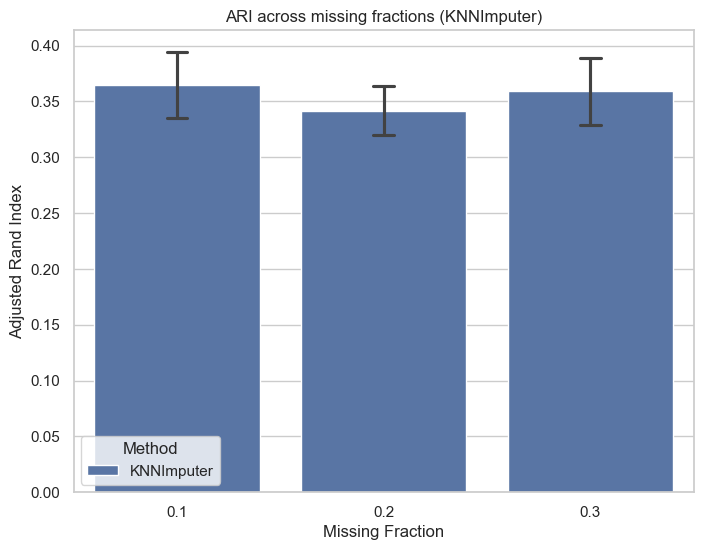

In [16]:
# Notebook 04: Performance Evaluation & Figures (KNN)

import scanpy as sc
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari_score

# -----------------------------
# Settings
# -----------------------------
sc.settings.verbosity = 0
sns.set(style="whitegrid")

ground_truth_path = "Data/adata_raw_qc.h5ad"     # ground truth file
imputed_dir = "imputed_knn"                      # folder with imputed h5ad files
methods = ["KNNImputer"]                         # method tag for plotting

# -----------------------------
# Preprocessing function
# -----------------------------
def preprocess_adata(adata, n_hvgs=1000):
    """Preprocess AnnData: unique names, HVGs, PCA, clustering."""
    adata = adata.copy()

    # Ensure unique obs/var names
    adata.obs_names_make_unique()
    adata.var_names_make_unique()

    # Handle NaNs/Infs in expression matrix
    X = adata.X.A if hasattr(adata.X, "A") else adata.X
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    adata.X = X

    # Apply log1p only if data not already logged
    if np.max(adata.X) > 30:
        sc.pp.log1p(adata)

    # HVG selection
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_hvgs)
    adata = adata[:, adata.var["highly_variable"]].copy()

    # PCA + neighbors + clustering
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata


# -----------------------------
# Load ground truth
# -----------------------------
print(" Preprocessing ground truth...")
adata_gt = sc.read_h5ad(ground_truth_path)
adata_gt = preprocess_adata(adata_gt)

if "leiden" not in adata_gt.obs:
    raise ValueError("Ground truth AnnData does not have 'leiden' clustering.")


# -----------------------------
# Evaluate imputation runs
# -----------------------------
results = []

for fname in os.listdir(imputed_dir):
    if not fname.endswith(".h5ad"):
        continue

    fpath = os.path.join(imputed_dir, fname)
    try:
        adata_imp = sc.read_h5ad(fpath)
        adata_imp = preprocess_adata(adata_imp)

        # Align cells
        common_cells = adata_gt.obs_names.intersection(adata_imp.obs_names)
        adata_gt_sub = adata_gt[common_cells]
        adata_imp_sub = adata_imp[common_cells]

        # Compute ARI
        ari = ari_score(adata_gt_sub.obs["leiden"], adata_imp_sub.obs["leiden"])

        # Parse metadata from filename (mfXX, runX)
        mf = None
        run = None
        for part in fname.split("_"):
            if part.startswith("mf"):
                mf = float(part.replace("mf", "").replace(".h5ad", "")) / 100
            if part.startswith("run"):
                run = int(part.replace("run", "").replace(".h5ad", ""))

        results.append({
            "file": fname,
            "method": "KNNImputer",
            "ARI": ari,
            "missing_fraction": mf,
            "run": run
        })

        print(f"✅ Processed {fname}: ARI={ari:.3f}")

    except Exception as e:
        print(f"❌ Error with {fname}: {e}")


# -----------------------------
# Results → DataFrame
# -----------------------------
results_df = pd.DataFrame(results)

if results_df.empty:
    raise ValueError("No results computed. Check your imputed files and pipeline.")

results_df = results_df.dropna(subset=["ARI", "missing_fraction"])
results_df["missing_fraction"] = results_df["missing_fraction"].astype(float)

# -----------------------------
# Summary
# -----------------------------
summary = results_df.groupby(["method", "missing_fraction"]).agg(
    ARI_mean=("ARI", "mean"),
    ARI_std=("ARI", "std"),
    runs=("ARI", "count")
).reset_index()

print("\nSummary (mean ± std):")
print(summary)


# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8, 6))
sns.barplot(
    data=results_df,
    x="missing_fraction",
    y="ARI",
    hue="method",
    errorbar="sd",
    capsize=0.1
)
plt.title("ARI across missing fractions (KNNImputer)")
plt.ylabel("Adjusted Rand Index")
plt.xlabel("Missing Fraction")
plt.legend(title="Method")
plt.show()


 Preprocessing ground truth...


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_softimpute_imputed_mf10_run1.h5ad: ARI=0.509
✅ Processed adata_softimpute_imputed_mf10_run10.h5ad: ARI=0.500
✅ Processed adata_softimpute_imputed_mf10_run2.h5ad: ARI=0.490
✅ Processed adata_softimpute_imputed_mf10_run3.h5ad: ARI=0.478
✅ Processed adata_softimpute_imputed_mf10_run4.h5ad: ARI=0.494
✅ Processed adata_softimpute_imputed_mf10_run5.h5ad: ARI=0.496
✅ Processed adata_softimpute_imputed_mf10_run6.h5ad: ARI=0.498
✅ Processed adata_softimpute_imputed_mf10_run7.h5ad: ARI=0.495
✅ Processed adata_softimpute_imputed_mf10_run8.h5ad: ARI=0.492
✅ Processed adata_softimpute_imputed_mf10_run9.h5ad: ARI=0.497
✅ Processed adata_softimpute_imputed_mf20_run1.h5ad: ARI=0.487
✅ Processed adata_softimpute_imputed_mf20_run10.h5ad: ARI=0.479
✅ Processed adata_softimpute_imputed_mf20_run2.h5ad: ARI=0.475
✅ Processed adata_softimpute_imputed_mf20_run3.h5ad: ARI=0.502
✅ Processed adata_softimpute_imputed_mf20_run4.h5ad: ARI=0.441
✅ Processed adata_softimpute_imputed_mf20_run5.h5ad: 

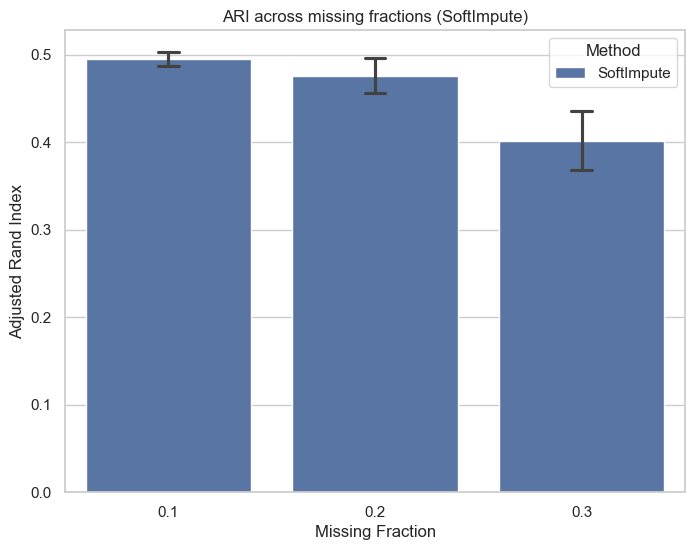

In [17]:
# Notebook 04: Performance Evaluation & Figures (SoftImpute)

import scanpy as sc
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari_score

# -----------------------------
# Settings
# -----------------------------
sc.settings.verbosity = 0
sns.set(style="whitegrid")

ground_truth_path = "Data/adata_raw_qc.h5ad"     # ground truth file
imputed_dir = "imputed_softimpute"               # folder with imputed h5ad files
methods = ["SoftImpute"]                         # method tag for plotting

# -----------------------------
# Preprocessing function
# -----------------------------
def preprocess_adata(adata, n_hvgs=1000):
    """Preprocess AnnData: unique names, HVGs, PCA, clustering."""
    adata = adata.copy()

    # Ensure unique obs/var names
    adata.obs_names_make_unique()
    adata.var_names_make_unique()

    # Handle NaNs/Infs in expression matrix
    X = adata.X.A if hasattr(adata.X, "A") else adata.X
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    adata.X = X

    # Apply log1p only if data not already logged
    if np.max(adata.X) > 30:
        sc.pp.log1p(adata)

    # HVG selection
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_hvgs)
    adata = adata[:, adata.var["highly_variable"]].copy()

    # PCA + neighbors + clustering
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata


# -----------------------------
# Load ground truth
# -----------------------------
print(" Preprocessing ground truth...")
adata_gt = sc.read_h5ad(ground_truth_path)
adata_gt = preprocess_adata(adata_gt)

if "leiden" not in adata_gt.obs:
    raise ValueError("Ground truth AnnData does not have 'leiden' clustering.")


# -----------------------------
# Evaluate imputation runs
# -----------------------------
results = []

for fname in os.listdir(imputed_dir):
    if not fname.endswith(".h5ad"):
        continue

    fpath = os.path.join(imputed_dir, fname)
    try:
        adata_imp = sc.read_h5ad(fpath)
        adata_imp = preprocess_adata(adata_imp)

        # Align cells
        common_cells = adata_gt.obs_names.intersection(adata_imp.obs_names)
        adata_gt_sub = adata_gt[common_cells]
        adata_imp_sub = adata_imp[common_cells]

        # Compute ARI
        ari = ari_score(adata_gt_sub.obs["leiden"], adata_imp_sub.obs["leiden"])

        # Parse metadata from filename (mfXX, runX)
        mf = None
        run = None
        for part in fname.split("_"):
            if part.startswith("mf"):
                mf = float(part.replace("mf", "").replace(".h5ad", "")) / 100
            if part.startswith("run"):
                run = int(part.replace("run", "").replace(".h5ad", ""))

        results.append({
            "file": fname,
            "method": "SoftImpute",
            "ARI": ari,
            "missing_fraction": mf,
            "run": run
        })

        print(f"✅ Processed {fname}: ARI={ari:.3f}")

    except Exception as e:
        print(f"❌ Error with {fname}: {e}")


# -----------------------------
# Results → DataFrame
# -----------------------------
results_df = pd.DataFrame(results)

if results_df.empty:
    raise ValueError("No results computed. Check your imputed files and pipeline.")

results_df = results_df.dropna(subset=["ARI", "missing_fraction"])
results_df["missing_fraction"] = results_df["missing_fraction"].astype(float)

# -----------------------------
# Summary
# -----------------------------
summary = results_df.groupby(["method", "missing_fraction"]).agg(
    ARI_mean=("ARI", "mean"),
    ARI_std=("ARI", "std"),
    runs=("ARI", "count")
).reset_index()

print("\nSummary (mean ± std):")
print(summary)


# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8, 6))
sns.barplot(
    data=results_df,
    x="missing_fraction",
    y="ARI",
    hue="method",
    errorbar="sd",
    capsize=0.1
)
plt.title("ARI across missing fractions (SoftImpute)")
plt.ylabel("Adjusted Rand Index")
plt.xlabel("Missing Fraction")
plt.legend(title="Method")
plt.show()


 Preprocessing ground truth...


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicat

✅ Processed adata_adata_gan_imputed_mf10_run1.h5ad: ARI=0.477


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf10_run10.h5ad: ARI=0.483


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf10_run2.h5ad: ARI=0.567


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf10_run3.h5ad: ARI=0.509


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf10_run4.h5ad: ARI=0.467


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf10_run5.h5ad: ARI=0.506


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf10_run6.h5ad: ARI=0.500


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf10_run7.h5ad: ARI=0.559


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf10_run8.h5ad: ARI=0.526


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf10_run9.h5ad: ARI=0.516


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf20_run1.h5ad: ARI=0.383


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf20_run10.h5ad: ARI=0.348


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf20_run2.h5ad: ARI=0.347


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf20_run3.h5ad: ARI=0.374


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf20_run4.h5ad: ARI=0.408


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf20_run5.h5ad: ARI=0.379


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf20_run6.h5ad: ARI=0.348


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf20_run7.h5ad: ARI=0.377


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf20_run8.h5ad: ARI=0.370


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf20_run9.h5ad: ARI=0.329


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf30_run1.h5ad: ARI=0.238


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf30_run10.h5ad: ARI=0.247


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf30_run2.h5ad: ARI=0.241


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf30_run3.h5ad: ARI=0.249


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf30_run4.h5ad: ARI=0.291


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf30_run5.h5ad: ARI=0.245


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf30_run6.h5ad: ARI=0.275


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf30_run7.h5ad: ARI=0.241


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf30_run8.h5ad: ARI=0.267


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Processed adata_adata_gan_imputed_mf30_run9.h5ad: ARI=0.257

Summary (mean ± std):
  method  missing_fraction  ARI_mean   ARI_std  runs
0    GAN               0.1  0.510826  0.032812    10
1    GAN               0.2  0.366285  0.023023    10
2    GAN               0.3  0.255157  0.017325    10


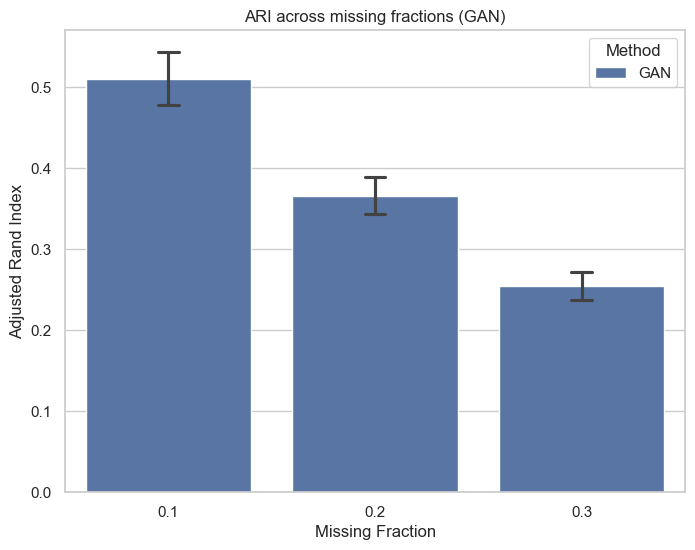

In [18]:
# Notebook 04: Performance Evaluation & Figures (SoftImpute)

import scanpy as sc
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari_score

# -----------------------------
# Settings
# -----------------------------
sc.settings.verbosity = 0
sns.set(style="whitegrid")

ground_truth_path = "Data/adata_raw_qc.h5ad"     # ground truth file
imputed_dir = "imputed_gan"               # folder with imputed h5ad files
methods = ["SoftImpute"]                         # method tag for plotting

# -----------------------------
# Preprocessing function
# -----------------------------
def preprocess_adata(adata, n_hvgs=1000):
    """Preprocess AnnData: unique names, HVGs, PCA, clustering."""
    adata = adata.copy()

    # Ensure unique obs/var names
    adata.obs_names_make_unique()
    adata.var_names_make_unique()

    # Handle NaNs/Infs in expression matrix
    X = adata.X.A if hasattr(adata.X, "A") else adata.X
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    adata.X = X

    # Apply log1p only if data not already logged
    if np.max(adata.X) > 30:
        sc.pp.log1p(adata)

    # HVG selection
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_hvgs)
    adata = adata[:, adata.var["highly_variable"]].copy()

    # PCA + neighbors + clustering
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata


# -----------------------------
# Load ground truth
# -----------------------------
print(" Preprocessing ground truth...")
adata_gt = sc.read_h5ad(ground_truth_path)
adata_gt = preprocess_adata(adata_gt)

if "leiden" not in adata_gt.obs:
    raise ValueError("Ground truth AnnData does not have 'leiden' clustering.")


# -----------------------------
# Evaluate imputation runs
# -----------------------------
results = []

for fname in os.listdir(imputed_dir):
    if not fname.endswith(".h5ad"):
        continue

    fpath = os.path.join(imputed_dir, fname)
    try:
        adata_imp = sc.read_h5ad(fpath)
        adata_imp = preprocess_adata(adata_imp)

        # Align cells
        common_cells = adata_gt.obs_names.intersection(adata_imp.obs_names)
        adata_gt_sub = adata_gt[common_cells]
        adata_imp_sub = adata_imp[common_cells]

        # Compute ARI
        ari = ari_score(adata_gt_sub.obs["leiden"], adata_imp_sub.obs["leiden"])

        # Parse metadata from filename (mfXX, runX)
        mf = None
        run = None
        for part in fname.split("_"):
            if part.startswith("mf"):
                mf = float(part.replace("mf", "").replace(".h5ad", "")) / 100
            if part.startswith("run"):
                run = int(part.replace("run", "").replace(".h5ad", ""))

        results.append({
            "file": fname,
            "method": "GAN",
            "ARI": ari,
            "missing_fraction": mf,
            "run": run
        })

        print(f"✅ Processed {fname}: ARI={ari:.3f}")

    except Exception as e:
        print(f"❌ Error with {fname}: {e}")


# -----------------------------
# Results → DataFrame
# -----------------------------
results_df = pd.DataFrame(results)

if results_df.empty:
    raise ValueError("No results computed. Check your imputed files and pipeline.")

results_df = results_df.dropna(subset=["ARI", "missing_fraction"])
results_df["missing_fraction"] = results_df["missing_fraction"].astype(float)

# -----------------------------
# Summary
# -----------------------------
summary = results_df.groupby(["method", "missing_fraction"]).agg(
    ARI_mean=("ARI", "mean"),
    ARI_std=("ARI", "std"),
    runs=("ARI", "count")
).reset_index()

print("\nSummary (mean ± std):")
print(summary)


# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8, 6))
sns.barplot(
    data=results_df,
    x="missing_fraction",
    y="ARI",
    hue="method",
    errorbar="sd",
    capsize=0.1
)
plt.title("ARI across missing fractions (GAN)")
plt.ylabel("Adjusted Rand Index")
plt.xlabel("Missing Fraction")
plt.legend(title="Method")
plt.show()


 Preprocessing ground truth...


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)



🔹 Processing method: SoftImpute
✅ SoftImpute | adata_softimpute_imputed_mf10_run1.h5ad: ARI=0.509
✅ SoftImpute | adata_softimpute_imputed_mf10_run10.h5ad: ARI=0.500
✅ SoftImpute | adata_softimpute_imputed_mf10_run2.h5ad: ARI=0.490
✅ SoftImpute | adata_softimpute_imputed_mf10_run3.h5ad: ARI=0.478
✅ SoftImpute | adata_softimpute_imputed_mf10_run4.h5ad: ARI=0.494
✅ SoftImpute | adata_softimpute_imputed_mf10_run5.h5ad: ARI=0.496
✅ SoftImpute | adata_softimpute_imputed_mf10_run6.h5ad: ARI=0.498
✅ SoftImpute | adata_softimpute_imputed_mf10_run7.h5ad: ARI=0.495
✅ SoftImpute | adata_softimpute_imputed_mf10_run8.h5ad: ARI=0.492
✅ SoftImpute | adata_softimpute_imputed_mf10_run9.h5ad: ARI=0.497
✅ SoftImpute | adata_softimpute_imputed_mf20_run1.h5ad: ARI=0.487
✅ SoftImpute | adata_softimpute_imputed_mf20_run10.h5ad: ARI=0.479
✅ SoftImpute | adata_softimpute_imputed_mf20_run2.h5ad: ARI=0.475
✅ SoftImpute | adata_softimpute_imputed_mf20_run3.h5ad: ARI=0.502
✅ SoftImpute | adata_softimpute_imputed_m

c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf10_run1.h5ad: ARI=0.324


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf10_run10.h5ad: ARI=0.318


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf10_run2.h5ad: ARI=0.360


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf10_run3.h5ad: ARI=0.314


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf10_run4.h5ad: ARI=0.346


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf10_run5.h5ad: ARI=0.274


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf10_run6.h5ad: ARI=0.294


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf10_run7.h5ad: ARI=0.324


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf10_run8.h5ad: ARI=0.334


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf10_run9.h5ad: ARI=0.296


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf20_run1.h5ad: ARI=0.265


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf20_run10.h5ad: ARI=0.258


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf20_run2.h5ad: ARI=0.242


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf20_run3.h5ad: ARI=0.247


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf20_run4.h5ad: ARI=0.253


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf20_run5.h5ad: ARI=0.232


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf20_run6.h5ad: ARI=0.283


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf20_run7.h5ad: ARI=0.252


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf20_run8.h5ad: ARI=0.261


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf20_run9.h5ad: ARI=0.262


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf30_run1.h5ad: ARI=0.231


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf30_run10.h5ad: ARI=0.211


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf30_run2.h5ad: ARI=0.213


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf30_run3.h5ad: ARI=0.217


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf30_run4.h5ad: ARI=0.222


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf30_run5.h5ad: ARI=0.214


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf30_run6.h5ad: ARI=0.213


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf30_run7.h5ad: ARI=0.203


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf30_run8.h5ad: ARI=0.229


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ MAGIC | adata_magic_imputed_mf30_run9.h5ad: ARI=0.209

🔹 Processing method: KNN


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf10_run1.h5ad: ARI=0.424


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf10_run10.h5ad: ARI=0.379


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf10_run2.h5ad: ARI=0.347


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf10_run3.h5ad: ARI=0.331


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf10_run4.h5ad: ARI=0.372


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf10_run5.h5ad: ARI=0.360


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf10_run6.h5ad: ARI=0.371


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf10_run7.h5ad: ARI=0.332


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf10_run8.h5ad: ARI=0.392


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf10_run9.h5ad: ARI=0.340


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf20_run1.h5ad: ARI=0.366


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf20_run10.h5ad: ARI=0.351
✅ KNN | adata_knn_imputed_mf20_run2.h5ad: ARI=0.366


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf20_run3.h5ad: ARI=0.346
✅ KNN | adata_knn_imputed_mf20_run4.h5ad: ARI=0.304


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf20_run5.h5ad: ARI=0.340


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf20_run6.h5ad: ARI=0.361


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf20_run7.h5ad: ARI=0.330


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf20_run8.h5ad: ARI=0.310


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ KNN | adata_knn_imputed_mf20_run9.h5ad: ARI=0.344
✅ KNN | adata_knn_imputed_mf30_run1.h5ad: ARI=0.393
✅ KNN | adata_knn_imputed_mf30_run10.h5ad: ARI=0.351
✅ KNN | adata_knn_imputed_mf30_run2.h5ad: ARI=0.354
✅ KNN | adata_knn_imputed_mf30_run3.h5ad: ARI=0.374
✅ KNN | adata_knn_imputed_mf30_run4.h5ad: ARI=0.380
✅ KNN | adata_knn_imputed_mf30_run5.h5ad: ARI=0.314
✅ KNN | adata_knn_imputed_mf30_run6.h5ad: ARI=0.390
✅ KNN | adata_knn_imputed_mf30_run7.h5ad: ARI=0.384
✅ KNN | adata_knn_imputed_mf30_run8.h5ad: ARI=0.336
✅ KNN | adata_knn_imputed_mf30_run9.h5ad: ARI=0.314

🔹 Processing method: Mean


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf10_run1.h5ad: ARI=0.434


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf10_run10.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf10_run2.h5ad: ARI=0.411


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf10_run3.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf10_run4.h5ad: ARI=0.427


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf10_run5.h5ad: ARI=0.401


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf10_run6.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf10_run7.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf10_run8.h5ad: ARI=0.413


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf10_run9.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf20_run1.h5ad: ARI=0.400


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf20_run10.h5ad: ARI=0.415


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf20_run2.h5ad: ARI=0.386


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf20_run3.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf20_run4.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf20_run5.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf20_run6.h5ad: ARI=0.417


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf20_run7.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf20_run8.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf20_run9.h5ad: ARI=0.400


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf30_run1.h5ad: ARI=0.396


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf30_run10.h5ad: ARI=0.404


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf30_run2.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf30_run3.h5ad: ARI=0.403


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf30_run4.h5ad: ARI=0.376


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf30_run5.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf30_run6.h5ad: ARI=0.381


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Mean | adata_mean_imputed_mf30_run7.h5ad: ARI=0.407


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf30_run8.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


❌ Error with adata_mean_imputed_mf30_run9.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

🔹 Processing method: GAN


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf10_run1.h5ad: ARI=0.477


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf10_run10.h5ad: ARI=0.483


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf10_run2.h5ad: ARI=0.567


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf10_run3.h5ad: ARI=0.509


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf10_run4.h5ad: ARI=0.467


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf10_run5.h5ad: ARI=0.506


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf10_run6.h5ad: ARI=0.500


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf10_run7.h5ad: ARI=0.559


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf10_run8.h5ad: ARI=0.526


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf10_run9.h5ad: ARI=0.516


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf20_run1.h5ad: ARI=0.383


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf20_run10.h5ad: ARI=0.348


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf20_run2.h5ad: ARI=0.347


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf20_run3.h5ad: ARI=0.374


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf20_run4.h5ad: ARI=0.408


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf20_run5.h5ad: ARI=0.379


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf20_run6.h5ad: ARI=0.348


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf20_run7.h5ad: ARI=0.377


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf20_run8.h5ad: ARI=0.370


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf20_run9.h5ad: ARI=0.329


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf30_run1.h5ad: ARI=0.238


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf30_run10.h5ad: ARI=0.247


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf30_run2.h5ad: ARI=0.241


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf30_run3.h5ad: ARI=0.249


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf30_run4.h5ad: ARI=0.291


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf30_run5.h5ad: ARI=0.245


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf30_run6.h5ad: ARI=0.275


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf30_run7.h5ad: ARI=0.241


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf30_run8.h5ad: ARI=0.267


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ GAN | adata_adata_gan_imputed_mf30_run9.h5ad: ARI=0.257

🔹 Processing method: Iterative


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf10_run1.h5ad: ARI=0.428


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf10_run10.h5ad: ARI=0.415


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf10_run2.h5ad: ARI=0.412


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf10_run3.h5ad: ARI=0.391


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf10_run4.h5ad: ARI=0.394


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf10_run5.h5ad: ARI=0.428


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf10_run6.h5ad: ARI=0.420


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf10_run7.h5ad: ARI=0.355


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf10_run8.h5ad: ARI=0.412


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf10_run9.h5ad: ARI=0.407


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf20_run1.h5ad: ARI=0.378


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf20_run10.h5ad: ARI=0.402
✅ Iterative | adata_iterative_imputed_mf20_run2.h5ad: ARI=0.367


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf20_run3.h5ad: ARI=0.357
✅ Iterative | adata_iterative_imputed_mf20_run4.h5ad: ARI=0.372


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf20_run5.h5ad: ARI=0.434


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf20_run6.h5ad: ARI=0.390


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf20_run7.h5ad: ARI=0.336


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf20_run8.h5ad: ARI=0.350


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


✅ Iterative | adata_iterative_imputed_mf20_run9.h5ad: ARI=0.397
✅ Iterative | adata_iterative_imputed_mf30_run1.h5ad: ARI=0.344
✅ Iterative | adata_iterative_imputed_mf30_run10.h5ad: ARI=0.230
✅ Iterative | adata_iterative_imputed_mf30_run2.h5ad: ARI=0.322
✅ Iterative | adata_iterative_imputed_mf30_run3.h5ad: ARI=0.274
✅ Iterative | adata_iterative_imputed_mf30_run4.h5ad: ARI=0.318
✅ Iterative | adata_iterative_imputed_mf30_run5.h5ad: ARI=0.281
✅ Iterative | adata_iterative_imputed_mf30_run6.h5ad: ARI=0.284
✅ Iterative | adata_iterative_imputed_mf30_run7.h5ad: ARI=0.389
✅ Iterative | adata_iterative_imputed_mf30_run8.h5ad: ARI=0.266
✅ Iterative | adata_iterative_imputed_mf30_run9.h5ad: ARI=0.317

Summary (mean ± std):
        method  missing_fraction  ARI_mean   ARI_std  runs
0          GAN               0.1  0.510826  0.032812    10
1          GAN               0.2  0.366285  0.023023    10
2          GAN               0.3  0.255157  0.017325    10
3    Iterative               0.1  0.

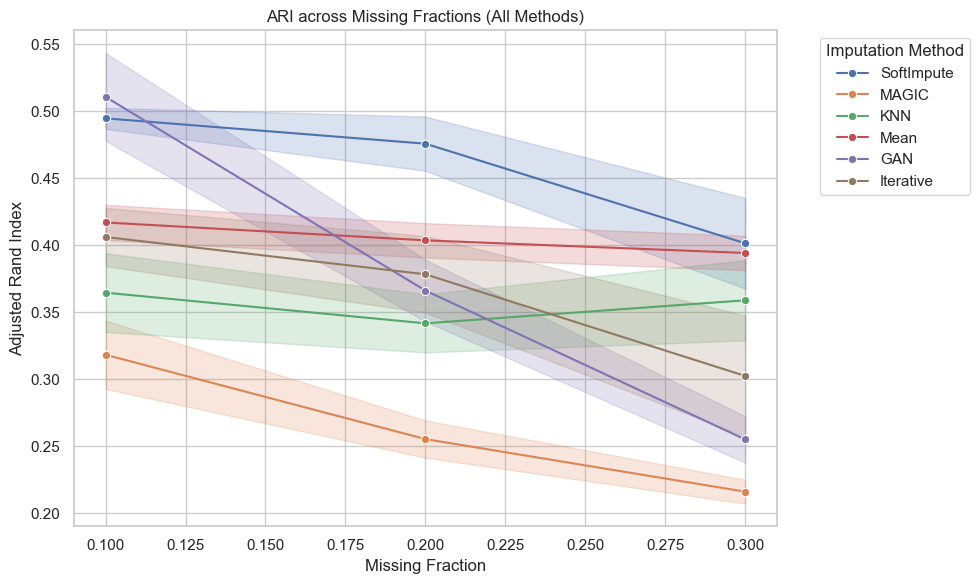

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari_score

# -----------------------------
# Settings
# -----------------------------
sc.settings.verbosity = 0
sns.set(style="whitegrid")

ground_truth_path = "Data/adata_raw_qc.h5ad"   # ground truth file
imputed_root = "imputed_h5ad"   

imputed_dirs = {
    "SoftImpute": "imputed_softimpute",
    "MAGIC": "imputed_h5ad",
    "KNN": "imputed_knn",
    "Mean": "imputed_mean",
    "GAN": "imputed_gan",
    "Iterative": "imputed_iterative"
}               # parent folder with subfolders per method

# Example folder structure:
# imputed_h5ad/
#   ├── gan/
#   ├── knn/
#   ├── softimpute/
#   └── iterative/

# -----------------------------
# Preprocessing function
# -----------------------------
def preprocess_adata(adata, n_hvgs=1000):
    adata = adata.copy()
    adata.obs_names_make_unique()
    adata.var_names_make_unique()

    X = adata.X.A if hasattr(adata.X, "A") else adata.X
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    adata.X = X

    if np.max(adata.X) > 30:
        sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_hvgs)
    adata = adata[:, adata.var["highly_variable"]].copy()

    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata

# -----------------------------
# Load ground truth
# -----------------------------
print(" Preprocessing ground truth...")
adata_gt = sc.read_h5ad(ground_truth_path)
adata_gt = preprocess_adata(adata_gt)

if "leiden" not in adata_gt.obs:
    raise ValueError("Ground truth AnnData does not have 'leiden' clustering.")

# -----------------------------
# Evaluate imputation runs
# -----------------------------
# -----------------------------
# Evaluate imputation runs across all methods
# -----------------------------
results = []

for method, method_dir in imputed_dirs.items():
    if not os.path.isdir(method_dir):
        print(f"⚠️ Skipping {method}, folder not found: {method_dir}")
        continue

    print(f"\n🔹 Processing method: {method}")
    for fname in os.listdir(method_dir):
        if not fname.endswith(".h5ad"):
            continue

        fpath = os.path.join(method_dir, fname)
        try:
            adata_imp = sc.read_h5ad(fpath)
            adata_imp = preprocess_adata(adata_imp)

            # Align cells
            common_cells = adata_gt.obs_names.intersection(adata_imp.obs_names)
            adata_gt_sub = adata_gt[common_cells]
            adata_imp_sub = adata_imp[common_cells]

            # Compute ARI
            ari = ari_score(adata_gt_sub.obs["leiden"], adata_imp_sub.obs["leiden"])

            # Parse metadata from filename
            mf, run = None, None
            for part in fname.split("_"):
                if part.startswith("mf"):
                    mf = float(part.replace("mf", "").replace(".h5ad", "")) / 100
                if part.startswith("run"):
                    run = int(part.replace("run", "").replace(".h5ad", ""))

            results.append({
                "file": fname,
                "method": method,
                "ARI": ari,
                "missing_fraction": mf,
                "run": run
            })

            print(f"✅ {method} | {fname}: ARI={ari:.3f}")

        except Exception as e:
            print(f"❌ Error with {fname}: {e}")

# -----------------------------
# Results → DataFrame
# -----------------------------
results_df = pd.DataFrame(results)
if results_df.empty:
    raise ValueError("No results computed. Check your imputed files and pipeline.")

results_df = results_df.dropna(subset=["ARI", "missing_fraction"])
results_df["missing_fraction"] = results_df["missing_fraction"].astype(float)

# -----------------------------
# Summary
# -----------------------------
summary = results_df.groupby(["method", "missing_fraction"]).agg(
    ARI_mean=("ARI", "mean"),
    ARI_std=("ARI", "std"),
    runs=("ARI", "count")
).reset_index()

print("\nSummary (mean ± std):")
print(summary)

# -----------------------------
# Plot: ARI vs Missing Fraction across Methods
# -----------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x="missing_fraction",
    y="ARI",
    hue="method",
    marker="o",
    err_style="band",  # shaded error region
    errorbar="sd"
)
plt.title("ARI across Missing Fractions (All Methods)")
plt.ylabel("Adjusted Rand Index")
plt.xlabel("Missing Fraction")
plt.legend(title="Imputation Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
